<a href="https://colab.research.google.com/github/ElahehSadeghabadi/E2E-Communication-based-on-Deep-Learning/blob/main/1_AWGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2025 ElahehSadeghabadi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Point-to-point, single-antenna transmission with an AWGN channel and no fading from the following paper:**

[1] T. O'Shea and J. Hoydis, "*An Introduction to Deep Learning for the Physical Layer,*" in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017.

# Setup

In [ ]:
import numpy as np
import tensorflow as tf
from math import ceil, log

# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Resetting the name counters
tf.keras.backend.clear_session()

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from IPython.display import Image, display

# System Model

Consider a point-to-point communication system:  
- The message $m\in\mathcal{M}$ is sent at one point, and $\hat{m}\in\mathcal{M}$ is detected at another point.
- Constraints on the encoded signal $\mathbf{x}\in\mathbb{R}^n$ can be one of the energy constraint, amplitude constraint, and average power constraint mentioned `Basics.ipynb`.
- Assuming $k = \log_2M$, $\left|\mathcal{M}\right| = M$, communication rate is $R = \frac{k}{n}\frac{\text{bits}}{\text{channel use}}$.
- The channel is described by $p\left(\mathbf{y}\mid\mathbf{x}\right)$.
- AWGN variance is $\beta = \left(2R\frac{E_b}{N_0}\right)^{-1}$, where $E_b$ is energy per bit and $N_0$ is noise power spectral density ratio.
- Evaluation metric can be block error rate (BLER), $p\left(\hat{m}\ne m\right)$.

To design such a communication system with deep learning, consider transmitter (Tx) and receiver (Rx) are made of neural networks (NNs). Here, the channel is AWGN. The end-to-end system is represented in Fig. 1.

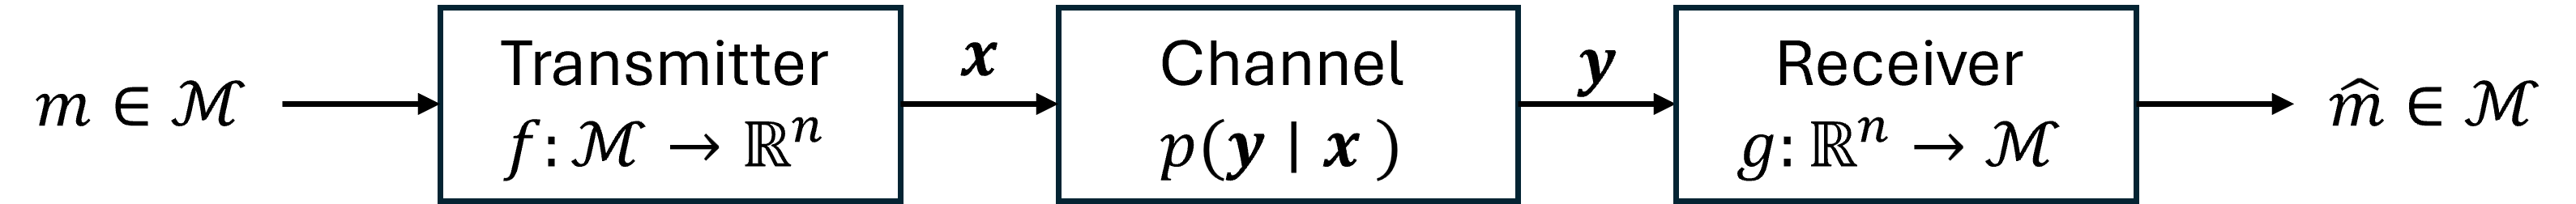

Figure 1: The system model of an end-to-end communication System.

## Deep Learning-Based Model

The transmitter and receiver layers considered in [1] for the AWGN system are as in Tables 1 and 2:

**Table 1: Tx Neural Network for AWGN system**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Input (one-hot encoding)|$M$|-|
|Dense|$M$|`relu`|
|Dense|$n$|`linear`|
|Normalization (transmitter constraint)|$n$|-|

The transmitter constraint can be one of the power, energy, or amplitude constraints.

**Table 2: Rx Neural Network for AWGN system**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Dense|$M$|`relu`|
|Dense|$M$|`softmax`|

The good point about this design is that the layers hyperparameters are based on the communication system parameters $M$ and $n$. I suppose it can improve scalability of the proposed model.

The above tables are for real signals. For complex signaling, $n$ is replaced by $2n$ to consider real and imaginary parts of the codewords.

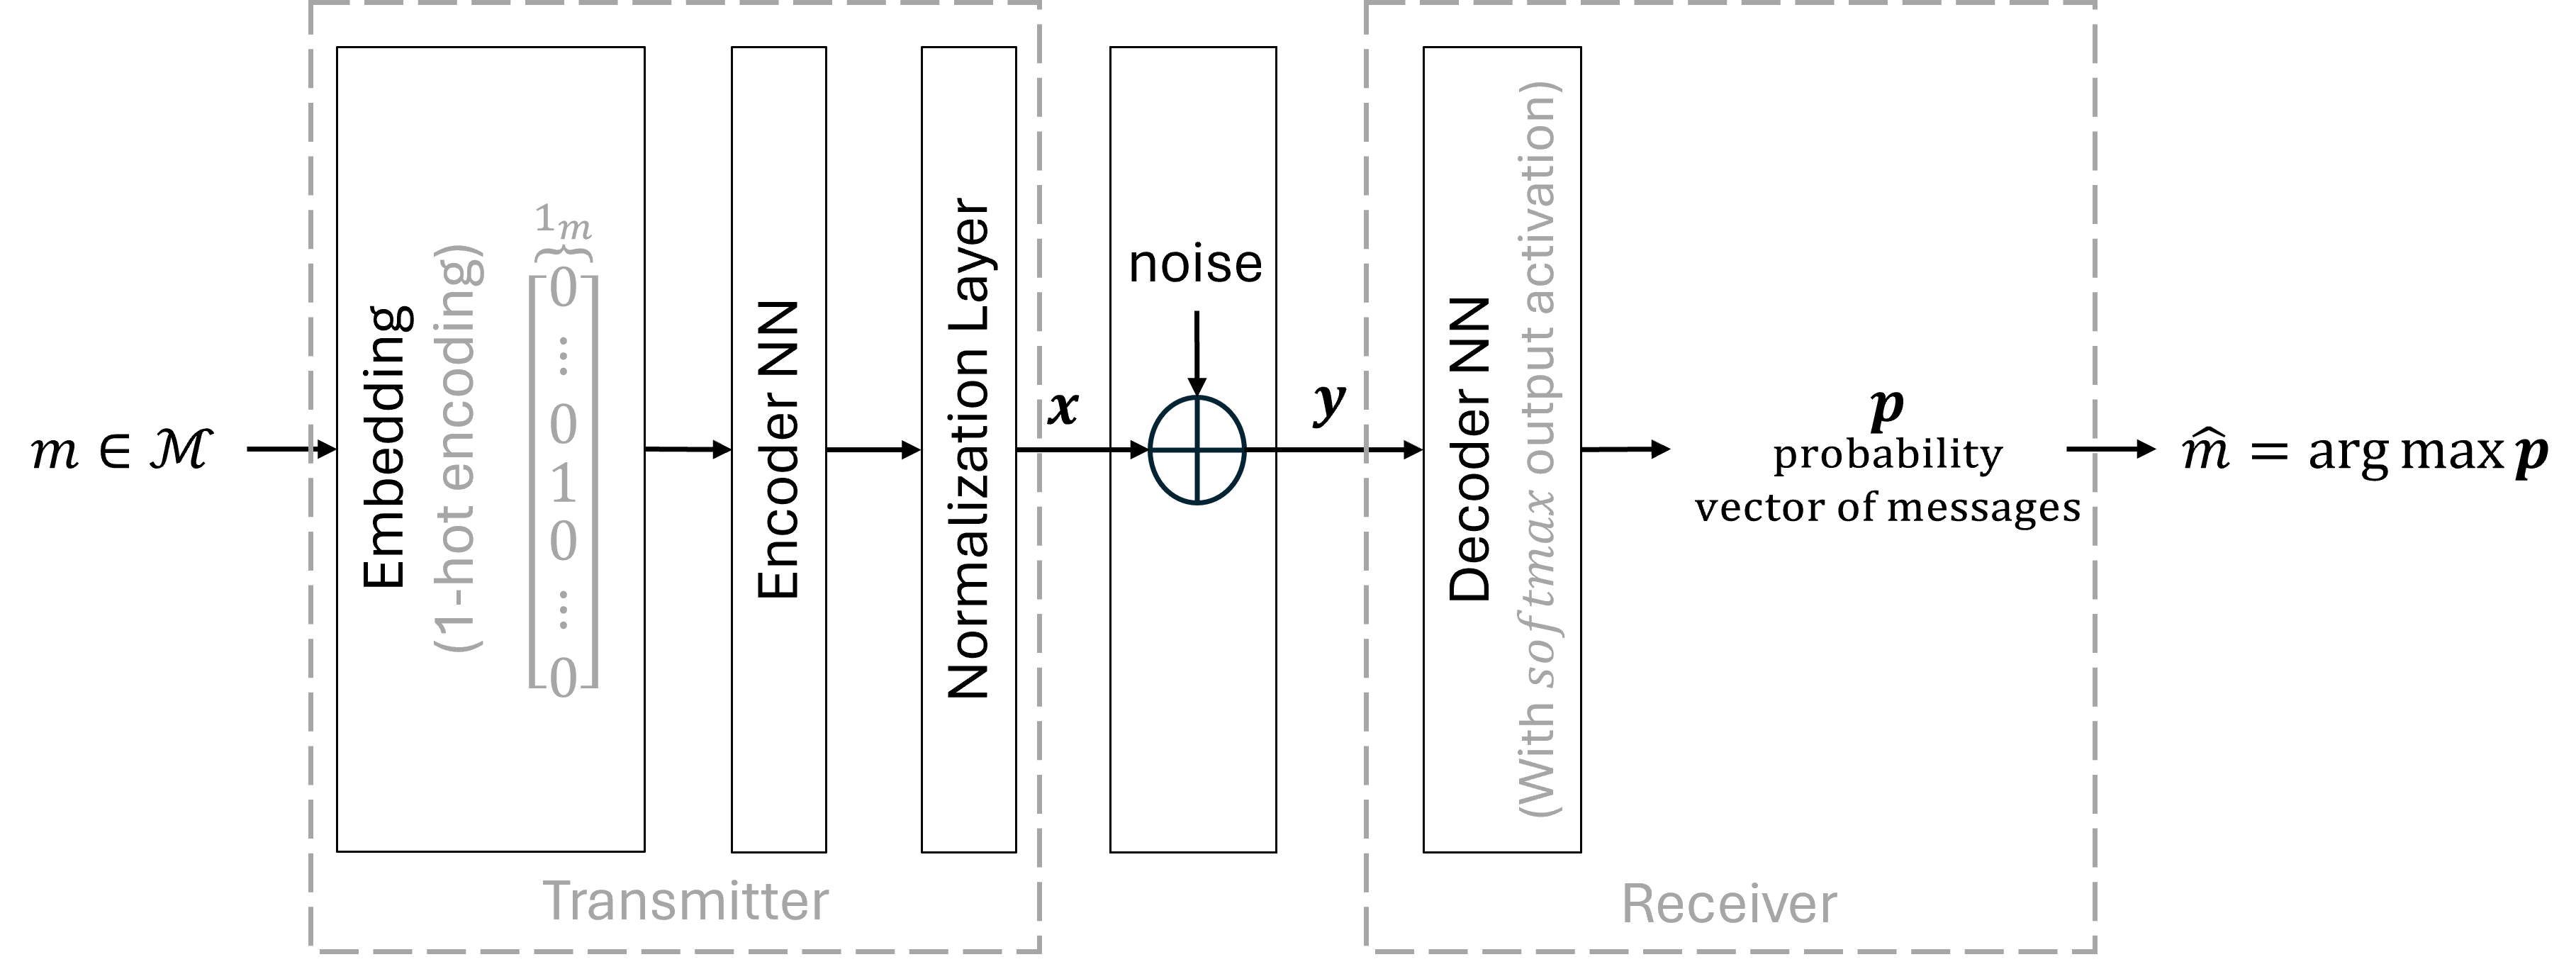

Figure 2: Autoencoder Representation of a Communication System over an AWGN Channel (based on [1, Figure 2])

# Creating and Training Models by TensorFlow and Keras

Before going forward to creating models by TensorFlow and Keras, don't forget to run the methods for transmitter constraints on codewords! These methods are in the following subsection, which are explained in detail in the file `Basics.ipynb`.

## Normalization (Transmitter Constraint)

Here the signaling is real and the transmitter constraint can be one of the *power*, *energy*, and *amplitude*.

Power constraint for real signaling:

In [ ]:
def power_constraint_for_real_signaling(x, power_limit = 1.0):
    """
    Applies an average power constraint of less than power_limit to each element of the real codeword.

    Args:
      x: Input tensor of shape (batch_size, n).
      power_limit: Power limit for each neuron.

    Returns:
      Tensor with constrained neuron outputs.
    """
    avg_power_per_neuron = tf.reduce_mean(tf.square(x), axis=0) # axis = 0: it forces averaging per neuron
    scale_factors = tf.where(avg_power_per_neuron > power_limit,
                            tf.math.sqrt(power_limit / avg_power_per_neuron),
                            tf.ones_like(avg_power_per_neuron))# tf.ones_like(ave_power_per_neuron) creates a tensor of one with the dimension of avg_power_per_neuron
    #---------------------------------------------------------------------------
    return x * tf.expand_dims(scale_factors, axis=0)

Energy constraint for real signaling:

In [ ]:
def energy_constraint_for_real_signaling(x):
    """
    Applies an average energy constraint of equal to n to each codeword.

    (norm(x))^2 = n

    Args:
      x: Input tensor of shape (batch_size, n).
      n: Length of the codeword.

    Returns:
      Tensor with constrained neuron outputs.
    """
    n_int = x.shape[-1]
    n_float = tf.cast(n_int, dtype=tf.float32)
    norm_of_x = tf.tile(tf.expand_dims(tf.math.sqrt(tf.reduce_sum(x**2,axis=-1)),axis=-1),[1,n_int])
    return tf.where(norm_of_x>tf.math.sqrt(n_float), tf.math.sqrt(n_float)*x/norm_of_x, x)

Amplitude constraint for real signaling:

In [ ]:
def amplitude_constraint_for_real_signaling(x):
    """
    Applies an amplitude constraint of equal to amp = 1.0 to each element of the codeword.

    Args:
      x: Input tensor of shape (batch_size, n).
      n: Length of the codeword.
      amp: Amplitude limit for each neuron.

    Returns:
      Tensor with constrained neuron outputs.
    """
    return tf.where(tf.abs(x)>1.0, x/tf.abs(x), x)

## Creating and Training Tx and Rx Models

The method `E2E_awgn` creates and trains the model with the layers mentioned above. The outputs of this method are the trained Tx and Rx, which can be used in evaluating the system by BLER and visualizing the Tx codeword constellation.

Notice that the communication system is trained for a certain value of $E_b/N_0$, then it is used for working at any values of $E_b/N_0$. According to [1], during training $E_b/N_0$ is set to 7dB.

In [ ]:
def E2E_awgn(n,k, constraint = "power", training_Eb_N0_dB = 7, n_samples = 50000, epochs = 50, batch_size = 1024, optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)):
  tf.random.set_seed(42)
  tf.keras.utils.set_random_seed(42)
  tf.keras.backend.clear_session()# Resetting the name counters
  M = 2**k
  R = k/n
  # Messages====================================================================
  # Generating random message from 0 to M-1:
  messages = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)#Generating random integers using tensorflow
  # One-hot encoding of messages:
  X_train = tf.one_hot(messages, M)

  #print(messages[0:M].numpy())
  #print(X_train[0:M].numpy())

  # Creating the model==========================================================
  # Transmitter-----------------------------------------------------------------
  # Transmitter model:
  inputs = tf.keras.layers.Input(shape = [M,])# one-hot encoding of length M is given as input to Tx
  tx_signal = tf.keras.layers.Dense(M, activation = "relu")(inputs)
  tx_signal = tf.keras.layers.Dense(n)(tx_signal)
  if constraint == "power":
    tx_signal = tf.keras.layers.Lambda(lambda x: power_constraint_for_real_signaling(x, power_limit = 1.0), output_shape = (n,))(tx_signal)
  elif constraint == "energy":
    tx_signal = tf.keras.layers.Lambda(lambda x: energy_constraint_for_real_signaling(x), output_shape = (n,))(tx_signal)
  elif constraint == "amplitude":
    tx_signal = tf.keras.layers.Lambda(lambda x: amplitude_constraint_for_real_signaling(x), output_shape = (n,))(tx_signal)

  tx_model = tf.keras.Model(inputs = inputs, outputs = tx_signal)
  # Channel---------------------------------------------------------------------
  # The E2E model is trained at Eb_N0 = training_Eb_N0_dB, but we use the trained model for all values of Eb_N0
  training_Eb_N0 = 10 ** (training_Eb_N0_dB/10) # 7dB
  noise_var = 1/(2*R*training_Eb_N0)
  noise_std = np.sqrt(noise_var)
  # ----------------------------------------------------------------------------
  ch_out = tf.keras.layers.GaussianNoise(noise_std)(tx_signal)
  ch_model = tf.keras.Model(inputs = tx_signal, outputs = ch_out)
  # Receiver--------------------------------------------------------------------
  rx_signal = tf.keras.layers.Dense(M, activation = "relu")(ch_out)
  rx_signal = tf.keras.layers.Dense(M, activation = "softmax")(rx_signal)
  rx_model = tf.keras.Model(inputs = ch_out, outputs = rx_signal)
  # E2E model-------------------------------------------------------------------
  e2e_model = tf.keras.Sequential([tx_model, ch_model, rx_model])

  # Compiling===================================================================
  e2e_model.compile(loss = "categorical_crossentropy", optimizer = optimizer)

  # Training====================================================================
  history = e2e_model.fit(X_train, X_train, epochs = epochs, batch_size = batch_size)

  return tx_model, rx_model

# Evaluating

BLER
------------------------------

In [ ]:
# Training hyperparameters:
constraint = 'power'
training_Eb_N0_dB = 7
n_samples = 100000
epochs = 50
batch_size= 1024
optimizer = tf.keras.optimizers.Adam
learning_rate=0.001

# Eb_N0 values in dB in BLER vs Eb_N0 plots:
Eb_N0_dB = np.linspace(-2,10,13)

# Simulation Scenario 1: (n,k) = (7,4)==========================================
n = 7
k = 4
M = 2**k
R = k/n

# Traning Tx and Rx models---
tx_model1, rx_model1 = E2E_awgn(n, k, constraint = constraint, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size= batch_size, optimizer = optimizer(learning_rate=learning_rate))

# Messages---
messages1 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)
messages_one_hot1 = tf.one_hot(messages1, M)# One-hot encoding

# Iterating the values of Eb_N0---
BLER1 = np.zeros(13,)
for i in range(13):
  # Tx:
  tx_signal1 = tx_model1(messages_one_hot1)

  # Noise layer:
  Eb_N0 = 10 ** (Eb_N0_dB[i]/10)
  noise_var = 1/(2*R*Eb_N0)
  noise_std = np.sqrt(noise_var)
  noise = tf.random.normal(shape = tx_signal1.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32,)
  noisy_signal1 = tx_signal1 + noise

  # Rx:
  rx_signal1 = rx_model1(noisy_signal1).numpy().argmax(axis = -1)

  # Counting the number of false prediction:------------------------------------
  BLER1[i] = np.count_nonzero(rx_signal1 != messages1) / n_samples

# Simulation Scenario 2: R=1 for (n,k)=[(2,2),(8,8)]============================
R = 1
# (n,k) = (2,2)-----------------------------------------------------------------
n = 2
k = 2
M = 2**k

# Traning Tx and Rx models---
tx_model2, rx_model2 = E2E_awgn(n, k, constraint = constraint, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size= batch_size, optimizer = optimizer(learning_rate=learning_rate))
# Messages--
messages2 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)
messages_one_hot2 = tf.one_hot(messages2, M)# One-hot encoding

# Iterating the values of Eb_N0---
BLER2 = np.zeros(13,)
for i in range(13):
  # Tx:
  tx_signal2 = tx_model2(messages_one_hot2)

  # Noise layer:
  Eb_N0 = 10 ** (Eb_N0_dB[i]/10)
  noise_var = 1/(2*R*Eb_N0)
  noise_std = np.sqrt(noise_var)
  noise = tf.random.normal(shape = tx_signal2.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32,)
  noisy_signal2 = tx_signal2 + noise

  # Rx:
  rx_signal2 = rx_model2(noisy_signal2).numpy().argmax(axis = -1)

  # Counting the number of false prediction:------------------------------------
  BLER2[i] = np.count_nonzero(rx_signal2 != messages2) / n_samples

# (n,k) = (8,8)-----------------------------------------------------------------
n = 8
k = 8
M = 2**k

# Traning Tx and Rx models---
tx_model3, rx_model3 = E2E_awgn(n, k, constraint = constraint, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size= batch_size, optimizer = optimizer(learning_rate=learning_rate))

# Messages--
messages3 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)
messages_one_hot3 = tf.one_hot(messages3, M)# One-hot encoding

# Iterating the values of Eb_N0---
BLER3 = np.zeros(13,)
for i in range(13):
  # Tx:
  tx_signal3 = tx_model3(messages_one_hot3)

  # Noise layer:
  Eb_N0 = 10 ** (Eb_N0_dB[i]/10)
  noise_var = 1/(2*R*Eb_N0)
  noise_std = np.sqrt(noise_var)
  noise = tf.random.normal(shape = tx_signal3.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32,)
  noisy_signal3 = tx_signal3 + noise

  # Rx:
  rx_signal3 = rx_model3(noisy_signal3).numpy().argmax(axis = -1)

  # Counting the number of false prediction:------------------------------------
  BLER3[i] = np.count_nonzero(rx_signal3 != messages3) / n_samples

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7063
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9989
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8139
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3352
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1631
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0975
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0669
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0384
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 16/50
98/98 ━

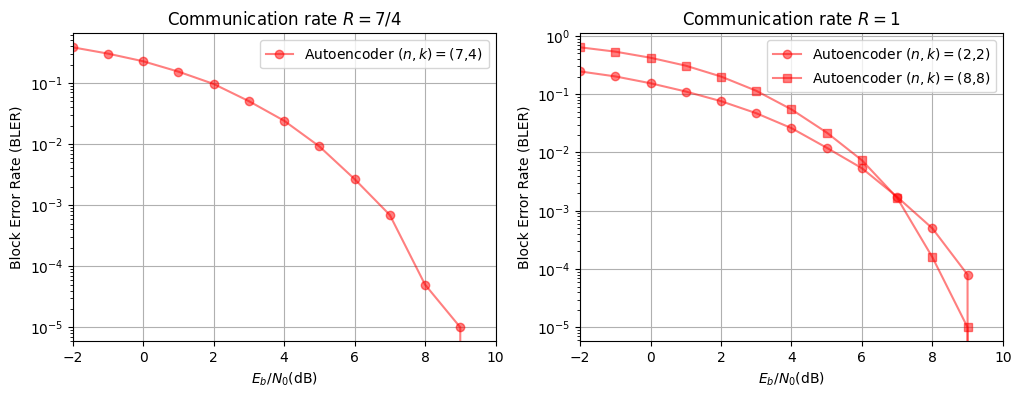

In [ ]:
# Plot--------------------------------------------------------------------------
# Simulation Scenario 1: (n,k) = (7,4)==========================================
n = 7
k = 4
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
BLER_plot1, = plt.plot(Eb_N0_dB, BLER1, 'r-o', label = 'Autoencoder '+r'$(n,k)=$' + f'({n},{k})')
BLER_plot1.set_alpha(0.5)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' +'(dB)')
plt.ylabel("Block Error Rate (BLER)")
plt.xlim([-2,10])
plt.yscale("log")
plt.title('Communication rate '+r'$R=$'+f'{n}/{k}')
plt.grid()

# Simulation Scenario 2: R=1 for (n,k)=[(2,2),(8,8)]============================
plt.subplot(1,2,2)
n = 2
k = 2
BLER_plot2, = plt.plot(Eb_N0_dB, BLER2, 'r-o', label = 'Autoencoder '+r'$(n,k)=$' + f'({n},{k})')
BLER_plot2.set_alpha(0.5)
n = 8
k = 8
BLER_plot3, = plt.plot(Eb_N0_dB, BLER3, 'r-s', label = 'Autoencoder '+r'$(n,k)=$' + f'({n},{k})')
BLER_plot3.set_alpha(0.5)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' +'(dB)')
plt.ylabel("Block Error Rate (BLER)")
plt.xlim([-2,10])
plt.yscale("log")
plt.title('Communication rate '+r'$R=1$')

plt.grid()
plt.savefig(f"AWGN_BLER_EbN0.png")
#plt.show()

The results obtained here are not as good as the curves represented in [1, Figure 3]. The exact value of the following parameters are not mentioned in the paper:
- Transmitter constraint
- Number of samples
- Epochs, and
- Batch size.

Probably, they are the cause of this difference.

## Visualizing Codeword Constellation

See `Basics.ipynb` for details about visualizing codeword constellation.

Here, the codeword constellation for four scenarios are desired:
1. $(n,k) = (2,2)$ with engergy constraint on codewords
2. $(n,k) = (2,4)$ with energy constraint on codewords
3. $(n,k) = (2,4)$ with power constraint on codewords
4. $(n,k) = (7,4)$ with power constraint on codewords


**Note:** For $n=7$, the codeword is not 2-D, so `t-sne` is used to represent codewords on a 2-D plot.

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3621
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1565
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0129
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9098
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8146
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6978
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5796
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5094
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4773
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4561
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4413
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4290
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4193
Epoch 14/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4106
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4021
Epoch 16/50
98/98 ━

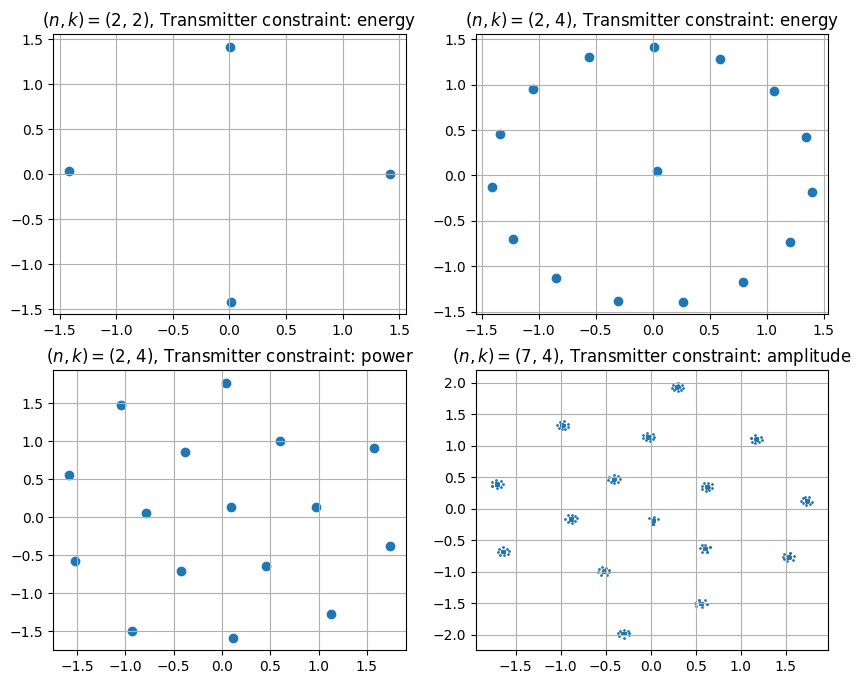

In [ ]:
# Training hyperparameters:
constraint = 'power'
training_Eb_N0_dB = 7
n_samples = 100000
epochs = 50
batch_size= 1024
optimizer = tf.keras.optimizers.Adam
learning_rate=0.001

# Four codeword constellations will be represented:
# 1. (n,k) = (2,2) with energy constraint on codewords
# 2. (n,k) = (2,4) with energy constraint on codewords
# 3. (n,k) = (2,4) with power constraint on codewords
# 4. (n,k) = (7,4) with power constraint on codewords

plt.figure(figsize=(10, 8))
for i, n, k, constraint in [(1,2,2,'energy'),(2,2,4,'energy'),(3,2,4,'power'),(4,7,4,'amplitude')]:
  M = 2**k
  tx_model, rx_model = E2E_awgn(n, k, constraint = constraint, training_Eb_N0_dB = training_Eb_N0_dB, n_samples = n_samples, epochs = epochs, batch_size= batch_size, optimizer = optimizer(learning_rate=learning_rate))
  if n > 2:
    messages = tf.reshape(tf.transpose(tf.reshape(tf.repeat(tf.range(M),100),[M,100])),[M*100,])
    symbols = tx_model.predict(tf.one_hot(messages,M))
    tsne = TSNE(n_components = 2, init="random", learning_rate="auto", random_state=42)
    symbols_2D = tsne.fit_transform(symbols)/20
  else:
    messages = tf.range(M)
    symbols = tx_model.predict(tf.one_hot(messages,M))
    symbols_2D = symbols
  plt.subplot(2,2,i)
  if i == 4:
    plt.scatter(symbols_2D[:, 0], symbols_2D[:, 1], s = 1)
  else:
    plt.scatter(symbols_2D[:, 0], symbols_2D[:, 1])
  #plt.xlim([-2,2])
  #plt.ylim([-2,2])
  plt.grid()
  plt.title(r'$(n,k)=$'+f"({n}, {k}), Transmitter constraint: {constraint}")

plt.savefig(f"AWGN_codewords.png")
# plt.show()
#plt.close()

The results obtained here are similar to [1,Figure 4]. However, the constellation for the $(n,k)=(2,4)$ with power constraint is not a perfect pentagon. By increasing the number of epochs, it will be more similar to a pentagon constellation.